<a href="https://colab.research.google.com/github/Mahrukhw/south-africa-chapter-mapping-urban-v/blob/main/Model_Training(Kmeans)_Disaster_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install opencv-python numpy matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#importing the libraries
from sklearn.preprocessing import StandardScaler
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import keras
import cv2
import os
from tensorflow.keras.preprocessing.image import img_to_array
%matplotlib inline
#import K-Means
from sklearn.cluster import KMeans
# important metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
path='/content/drive/MyDrive/DisasterImages/'

In [ ]:
data = []
label = []
c = 0
d = 0
IMG_SIZE = 300
for file in os.listdir(path):
    img=cv2.imread(path+file)
    img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
    #img=cv2.resize(img, IMG_SIZE)
    img=img.astype('float32')
    if file[:3]=='disaster':
        if c==500: continue
        c+=1
        label.append("disaster")
    else:
        if d==500: continue
        d+=1
        label.append("nondisaster")
    data.append(img)
data = np.array(data)

## Pre Processing


In [ ]:
#We have stored all labels in integer format to data_label.
#Contents of data_label will be 0 and 1. 0 for the violent and 1 for the nonviolent.
data_label = []
for i in label:
    if i=="disaster": data_label.append(0)
    else: data_label.append(1)
data_label = np.array(data_label)

In [ ]:
data = data/255.0
reshaped_data = data.reshape(len(data),-1)
reshaped_data.shape

(500, 270000)

## Standard Kmeans

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(reshaped_data)
kmeans.cluster_centers_.shape

(2, 270000)

# SCATTER PLOT OF CENTROIDS

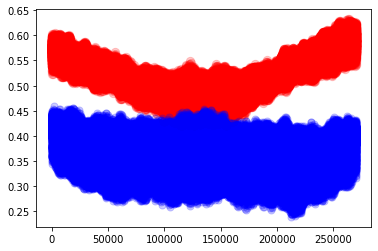

In [ ]:
x_data = [i for i in range(270000)]
plt.scatter(x_data,kmeans.cluster_centers_[0], color = 'red',alpha=0.2,s=70)
plt.scatter(x_data,kmeans.cluster_centers_[1] , color = 'blue',alpha=0.2,s=50)

# MAPPING THE LABELS

In [ ]:
# mapping labels from cluster to original labels
def get_reference_dict(clusters,data_label):
    reference_label = {}
    # For loop to run through each label of cluster label
    for i in range(len(np.unique(clusters))):
        index = np.where(clusters == i,1,0)
        num = np.bincount(data_label[index==1]).argmax()
        reference_label[i] = num
    return reference_label
# Mapping predictions to original labels
def get_labels(clusters,refernce_labels):
    temp_labels = np.random.rand(len(clusters))
    for i in range(len(clusters)):
        temp_labels[i] = reference_labels[clusters[i]]
    return temp_labels

# checking the accuracy of our model

In [ ]:
reference_labels = get_reference_dict(clusters,data_label)
predicted_labels = get_labels(clusters,reference_labels)
print(accuracy_score(predicted_labels,data_label))

1.0


## ELBOW METHOD

Accuracy for k = 2:  1.0
Accuracy for k = 16:  1.0
Accuracy for k = 64:  1.0
Accuracy for k = 100:  1.0


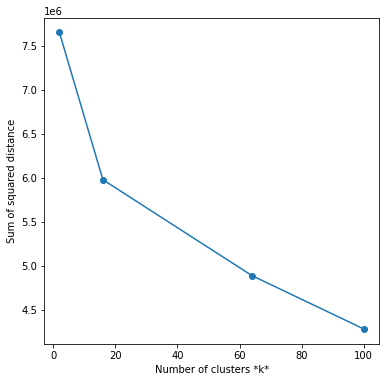

In [13]:
sse = []
list_k = [2,16,64,100]
for k in list_k:
    km = KMeans(n_clusters=k)
    clusters = km.fit_predict(reshaped_data)
    sse.append(km.inertia_)
    reference_labels = get_reference_dict(clusters,data_label)
    predicted_labels = get_labels(clusters,reference_labels)
    print(f"Accuracy for k = {k}: ", accuracy_score(predicted_labels,data_label))
# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

#Transfer Learning

In [21]:
import keras
import tensorflow
#from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
#from tensorflow.keras.utils import img_to_array
#from tensorflow.keras.preprocessing import image

In [32]:
!pip install keras
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
#importing libraries
import keras
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing import image

In [40]:
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE,3))


94765736/94765736 [==============================] - 3s 0us/step


In [41]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 306, 306, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 150, 150, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

# FEATURE EXTRACTION

In [42]:
from tensorflow.keras.preprocessing.image import img_to_array
def extract_vector(data_holder):

    resnet_feature_list = []

    for im in data_holder:
        im = image.img_to_array(im)
        img = preprocess_input(np.expand_dims(im.copy(), axis=0))
        resnet_feature = model.predict(img)
        resnet_feature_np = np.array(resnet_feature)
        resnet_feature_list.append(resnet_feature_np.flatten())
    return np.array(resnet_feature_list)

#KMEANS MODIFIED

In [43]:
array = extract_vector(data)
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(array)

1/1 [==============================] - 0s 24ms/step


In [44]:
kmeans.cluster_centers_.shape

(2, 204800)